<a href="https://colab.research.google.com/github/Joe-rini/nlp-specialization-colab/blob/main/C1W3_L2_Embeddings_Teaching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C1W3_L2: Word Embeddings & Analogies

In this notebook, you'll manipulate word embeddings using NumPy. You'll start with a toy example to build intuition, then load real pre-trained vectors to explore analogies like:

> `king - man + woman ≈ queen`

You'll also build an interactive analogy explorer using Gradio.

## 🧪 Toy Example – Vector Arithmetic

In [1]:
import numpy as np

# Fake vectors (3D)
baby = np.array([1, 0, 0])
dog = np.array([0, 1, 0])
puppy = baby + dog

print("baby + dog =", puppy)
print("baby - dog =", baby - dog)
print("puppy - baby =", puppy - baby)

baby + dog = [1 1 0]
baby - dog = [ 1 -1  0]
puppy - baby = [0 1 0]


## 📦 Load Pre-trained Word Embeddings
The below code will download an embeddings file to be used in the rest of the workbook. You'll have to suspend belief in terms of how LLM embedding models work for now and just use the models as is.

The model used is the Google News Word2Vec model: a static word embedding trained on 100 billion words using the skip-gram architecture. It produces one fixed 300-dimensional vector per word, capturing semantic relationships like king - man + woman ≈ queen, but without context awareness — the word "bank" always has the same vector, regardless of meaning.

In contrast, models like OpenAI's Ada (text-embedding-3-small) are contextual embeddings generated by transformer models: the embedding for a word or sentence depends on the entire input. This allows them to distinguish between different meanings of the same word and represent full passages more richly.

In [3]:
!wget https://raw.githubusercontent.com/Joe-rini/nlp-specialization-colab/main/week3/word_embeddings_subset.p
import pickle

with open("word_embeddings_subset.p", "rb") as f:
    word_embeddings = pickle.load(f)
print(f"Loaded {len(word_embeddings)} embeddings.")


--2025-07-24 18:28:54--  https://raw.githubusercontent.com/Joe-rini/nlp-specialization-colab/main/week3/word_embeddings_subset.p
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 309156 (302K) [application/octet-stream]
Saving to: ‘word_embeddings_subset.p’

word_embeddings_sub 100%[===================>] 301.91K  --.-KB/s    in 0.04s   

2025-07-24 18:28:54 (7.25 MB/s) - ‘word_embeddings_subset.p’ saved [309156/309156]

Loaded 243 embeddings.


## 🔍 Inspect an Embedding
Let's look at a single embedding: the first 10 dimensions.

In [4]:
vec_king = word_embeddings['king']
print(f"Vector for 'king' (first 10 dims):\n{vec_king[:10]}")

Vector for 'king' (first 10 dims):
[ 0.12597656  0.02978516  0.00860596  0.13964844 -0.02563477 -0.03613281
  0.11181641 -0.19824219  0.05126953  0.36328125]


And let's visualize a view embeddings. First let's print 50 of the words.

In [20]:
print(list(word_embeddings.keys())[:243])  # See first 50 words


['country', 'city', 'China', 'Iraq', 'oil', 'town', 'Canada', 'London', 'England', 'Australia', 'Japan', 'Pakistan', 'Iran', 'gas', 'happy', 'Russia', 'Afghanistan', 'France', 'Germany', 'Georgia', 'Baghdad', 'village', 'Spain', 'Italy', 'Beijing', 'Jordan', 'Paris', 'Ireland', 'Turkey', 'Egypt', 'Lebanon', 'Taiwan', 'Tokyo', 'Nigeria', 'Vietnam', 'Moscow', 'Greece', 'Indonesia', 'sad', 'Syria', 'Thailand', 'Libya', 'Zimbabwe', 'Cuba', 'Ottawa', 'Tehran', 'Sudan', 'Kenya', 'Philippines', 'Sweden', 'Poland', 'Ukraine', 'Rome', 'Venezuela', 'Switzerland', 'Berlin', 'Bangladesh', 'Portugal', 'Ghana', 'Athens', 'king', 'Madrid', 'Somalia', 'Dublin', 'Qatar', 'Chile', 'Islamabad', 'Bahrain', 'Nepal', 'Norway', 'Serbia', 'Kabul', 'continent', 'Brussels', 'Belgium', 'Uganda', 'petroleum', 'Cairo', 'Denmark', 'Austria', 'Jamaica', 'Georgetown', 'Bangkok', 'Finland', 'Peru', 'Romania', 'Bulgaria', 'Hungary', 'Vienna', 'Kingston', 'Manila', 'Cyprus', 'Azerbaijan', 'Copenhagen', 'Fiji', 'Tunisia'

Let's show the words and their embeddings in a "Vector Database"

In [26]:
import numpy as np
import pandas as pd

# 1. Create the DataFrame from the word_embeddings dictionary
keys = list(word_embeddings.keys())
data = [word_embeddings[key] for key in keys]
embedding = pd.DataFrame(data=data, index=keys)

# 2. Function to find the closest word to a given vector
def find_closest_word(v, k=1):
    # Compute squared Euclidean distances
    diff = embedding.values - v
    delta = np.sum(diff * diff, axis=1)
    i = np.argmin(delta)
    return embedding.iloc[i].name

# 3. Preview the top 10 words and their first few vector dimensions
embedding.head(10)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
country,-0.080078,0.133789,0.143555,0.094727,-0.047363,-0.023560,-0.008545,-0.186523,0.045898,-0.081543,...,-0.145508,0.067383,-0.244141,-0.077148,0.047607,-0.075195,-0.149414,-0.044189,0.097168,0.067383
city,-0.010071,0.057373,0.183594,-0.040039,-0.029785,-0.079102,0.071777,0.013306,-0.143555,0.011292,...,0.024292,-0.168945,-0.062988,0.117188,-0.020508,0.030273,-0.247070,-0.122559,0.076172,-0.234375
China,-0.073242,0.135742,0.108887,0.083008,-0.127930,-0.227539,0.151367,-0.045654,-0.065430,0.034424,...,0.140625,0.087402,0.152344,0.079590,0.006348,-0.037842,-0.183594,0.137695,0.093750,-0.079590
Iraq,0.191406,0.125000,-0.065430,0.060059,-0.285156,-0.102539,0.117188,-0.351562,-0.095215,0.200195,...,-0.100586,-0.077148,-0.123047,0.193359,-0.153320,0.089355,-0.173828,-0.054688,0.302734,0.105957
oil,-0.139648,0.062256,-0.279297,0.063965,0.044434,-0.154297,-0.184570,-0.498047,0.047363,0.110840,...,-0.195312,-0.345703,0.217773,-0.091797,0.051025,0.061279,0.194336,0.204102,0.235352,-0.051025
town,0.123535,0.159180,0.030029,-0.161133,0.015625,0.111816,0.039795,-0.196289,-0.039307,0.067871,...,-0.007935,-0.091797,-0.265625,0.029297,0.089844,-0.049805,-0.202148,-0.079590,0.068848,-0.164062
Canada,-0.136719,-0.154297,0.269531,0.273438,0.086914,-0.076172,-0.018677,0.006256,0.077637,-0.211914,...,0.105469,0.030762,-0.039307,0.183594,-0.117676,0.191406,0.074219,0.020996,0.285156,-0.257812
London,-0.267578,0.092773,-0.238281,0.115234,-0.006836,0.221680,-0.251953,-0.055420,0.020020,0.149414,...,-0.008667,-0.008484,-0.053223,0.197266,-0.296875,0.064453,0.091797,0.058350,0.022583,-0.101074
England,-0.198242,0.115234,0.062500,-0.058350,0.226562,0.045898,-0.062256,-0.202148,0.080566,0.021606,...,0.135742,0.109375,-0.121582,0.008545,-0.171875,0.086914,0.070312,0.003281,0.069336,0.056152
Australia,0.048828,-0.194336,-0.041504,0.084473,-0.114258,-0.208008,-0.164062,-0.269531,0.079102,0.275391,...,0.021118,0.171875,0.042236,0.221680,-0.239258,-0.106934,0.030884,0.006622,0.051270,-0.135742


And visualize the first 5 in 2D and 3D space

First 50 words in the embedding subset:
 ['country', 'city', 'China', 'Iraq', 'oil', 'town', 'Canada', 'London', 'England', 'Australia', 'Japan', 'Pakistan', 'Iran', 'gas', 'happy', 'Russia', 'Afghanistan', 'France', 'Germany', 'Georgia', 'Baghdad', 'village', 'Spain', 'Italy', 'Beijing', 'Jordan', 'Paris', 'Ireland', 'Turkey', 'Egypt', 'Lebanon', 'Taiwan', 'Tokyo', 'Nigeria', 'Vietnam', 'Moscow', 'Greece', 'Indonesia', 'sad', 'Syria', 'Thailand', 'Libya', 'Zimbabwe', 'Cuba', 'Ottawa', 'Tehran', 'Sudan', 'Kenya', 'Philippines', 'Sweden']


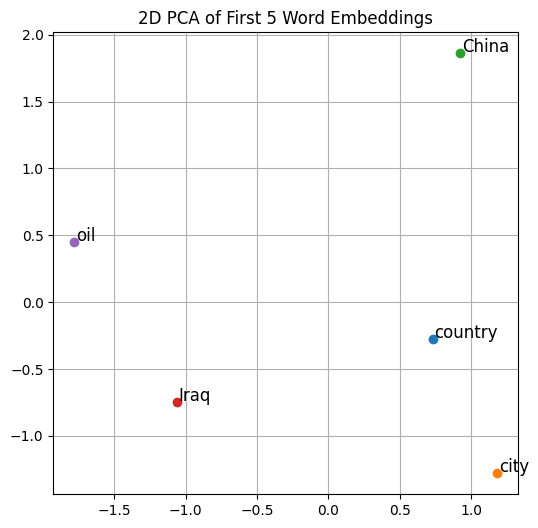

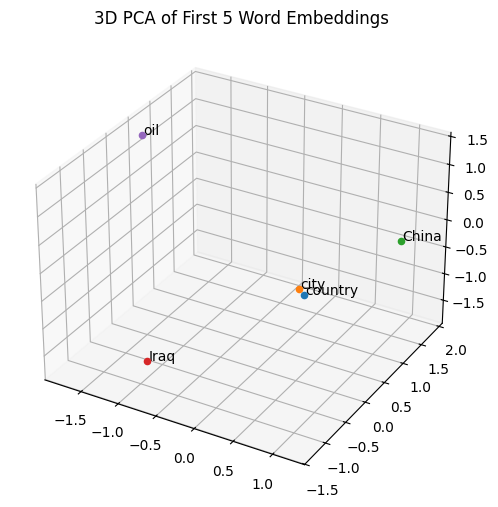

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Extract and display first 50 words
words = list(word_embeddings.keys())
print("First 50 words in the embedding subset:\n", words[:50])

# Step 2: Use first 5 valid words
words_to_plot = words[:5]
vectors = np.array([word_embeddings[w] for w in words_to_plot])

# Step 3: 2D PCA
pca_2d = PCA(n_components=2)
vectors_2d = pca_2d.fit_transform(vectors)

plt.figure(figsize=(6, 6))
for i, word in enumerate(words_to_plot):
    x, y = vectors_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=12)
plt.title("2D PCA of First 5 Word Embeddings")
plt.grid(True)
plt.show()

# Step 4: 3D PCA
pca_3d = PCA(n_components=3)
vectors_3d = pca_3d.fit_transform(vectors)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for i, word in enumerate(words_to_plot):
    x, y, z = vectors_3d[i]
    ax.scatter(x, y, z)
    ax.text(x + 0.01, y + 0.01, z + 0.01, word, fontsize=10)
ax.set_title("3D PCA of First 5 Word Embeddings")
plt.show()


## 🧠 Cosine Similarity Function

In [12]:
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

## 🤖 Analogy Function: `vec2 - vec1 + vec3`

In [23]:
def analogy(w1, w2, w3):
    try:
        e1, e2, e3 = word_embeddings[w1], word_embeddings[w2], word_embeddings[w3]
    except KeyError as e:
        return f"Missing word in vocabulary: {e.args[0]}"

    target = e2 - e1 + e3

    best_word = None
    best_sim = -1
    for word, emb in word_embeddings.items():
        if word in [w1, w2, w3]:
            continue
        sim = cosine_similarity(target, emb)
        if sim > best_sim:
            best_sim = sim
            best_word = word
    return best_word


## 🔎 Try Some Analogies

In [24]:
print("France : Paris :: Germany :", analogy("France", "Paris", "Germany"))   # → Berlin
print("Italy : Rome :: Spain :", analogy("Italy", "Rome", "Spain"))           # → Madrid
print("Russia : Moscow :: Japan :", analogy("Russia", "Moscow", "Japan"))     # → Tokyo
print("Canada : Ottawa :: Australia :", analogy("Canada", "Ottawa", "Australia"))  # → Canberra

France : Paris :: Germany : Berlin
Italy : Rome :: Spain : Madrid
Russia : Moscow :: Japan : Tokyo
Canada : Ottawa :: Australia : Canberra


In [25]:
print("happy : joyful :: sad :", analogy("happy", "joyful", "sad"))           # → ??? (maybe 'depressed' if present)


happy : joyful :: sad : Lebanon
